In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=16)
parser.add_argument("--nout", type=int, default=10)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=400)
args, unknown = parser.parse_known_args()
args = vars(args)
#args = vars(parser.parse_args())
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]

In [3]:
lattice = lt.Lattice(lt.D3Q27, device = "cpu", dtype=torch.float64)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=0.05, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

In [4]:
interval_vtk=1#int((flow.units.convert_time_to_lu(tmax))/200)
interval_out=1#int((flow.units.convert_time_to_lu(tmax))/200)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
steps = int(flow.units.convert_time_to_lu(tmax))
print(steps)
#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
882


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
steps = 10
mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)

Performance in MLUPS: 1.3104682222017205
10


In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)

dissipationEkin=np.array([energy[:,1],-1/(np.pi*2)**3*np.gradient(energy[:,2],energy[:,1])])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)




[0.         0.04534498 0.09068997]


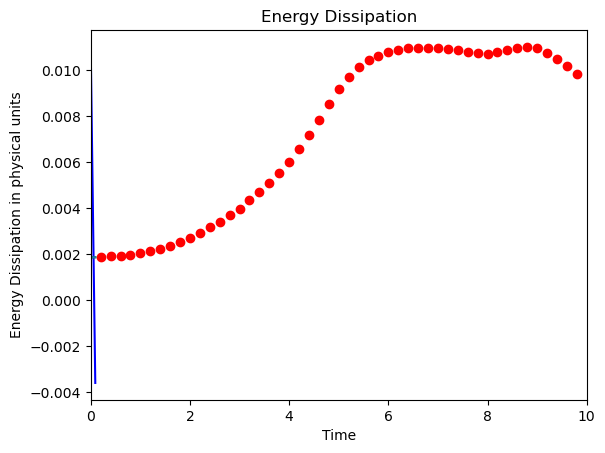

In [7]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re400.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(dissipationEkin[0,:])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()